In [44]:
import cmocean
import matplotlib

import numpy as np
import xarray as xr
import xeofs as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from functions.latex import set_size



datadir = "../data/"
figdir = "../figures/"

In [46]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

def plot_func(var, ax, transform, **kwargs):
    if transform:
        cb = ax.scatter(x=var.lon, y=var.lat, c=var, transform=ccrs.PlateCarree(), **kwargs)
        ax.add_feature(cfeature.LAND, color="grey", zorder=100)
    else:
        cb = ax.scatter(x=var.x, y=var.y, c=var, **kwargs)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    return cb, ax

region_contours = {
    #"arctic_ocean" : [800, 1000, 1250, 1500, 1800, 2000, 2300],
    "arctic_ocean" : [1000, 1200, 1400, 1600, 1800, 2000, 2200],
    #"canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3750],
    "canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    "makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    "eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    #"greenland_basin" : [2550, 2625, 2800, 3000, 3200, 3400, 3600],
    #"greenland_basin" : [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700],
    "greenland_basin" : [2600, 2800, 3000, 3200, 3400, 3600],
    #"norwegian_seas" : [2500, 2700, 2900, 3050],
    "norwegian_seas" : [2700, 2800, 2900, 3000, 3100, 3200],
    #"lofoten_basin" : [3150, 3200],
    "lofoten_basin" : [3350, 3400, 3450],
    #"norwegian_basin" : [3150, 3275, 3450, 3600]
    #"norwegian_basin" : [3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900]
    "norwegian_basin" : [3400, 3500, 3600, 3700, 3800, 3900]
}

In [70]:
mdt = "dtu"
hydrography = "woa"
transform = True

In [71]:
ds = xr.merge([xr.open_dataset(datadir + f"velocities_{mdt}_{hydrography}_ease.nc"),
               xr.open_dataset(datadir + "bathymetry_with_gradients_filter50_ease.nc")
              ]
             )
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB 47.33 47.5 47.67 47.84 ... 47.67 47.5 47.33
    lon      (y, x) float32 279kB -45.0 -44.78 -44.56 ... 135.4 135.2 135.0
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    mdt      (y, x) float64 558kB ...
    us       (y, x) float64 558kB ...
    vs       (y, x) float64 558kB ...
    ut       (y, x) float64 558kB ...
    vt       (y, x) float64 558kB ...
    ub       (y, x) float64 558kB ...
    vb       (y, x) float64 558kB ...
    depth    (y, x) float64 558kB ...
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...
Attributes:
    long_name:     mean ocean dynamic topography
    units:         m
    actual_range:  [-2.205  2.457]

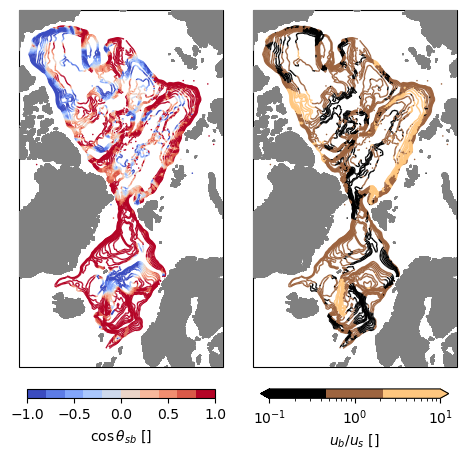

In [74]:
cmap_0 = plt.get_cmap('coolwarm', 10)
cmap_1 = plt.get_cmap('copper', 3)

if transform:
    fig, ax = plt.subplots(1, 2,
                           #figsize=set_size(width="AGU"),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
    proj = "latlon"
else: 
    fig, ax = plt.subplots(1, 2,
                           sharex=True,
                           sharey=True
                           #figsize=set_size(width="AGU"),
                          )
    proj = "xy"

for region_name in region_contours:
    region = get_region_coords(region_name, xy=True)
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        speed_b = np.sqrt(ds_interp["ub"]**2 + ds_interp["vb"]**2)
        speed_s = np.sqrt(ds_interp["us"]**2 + ds_interp["vs"]**2)
        ds_interp["eb"] = (ds_interp["us"]*ds_interp["ub"] + ds_interp["vs"]*ds_interp["vb"])/(speed_b*speed_s)
        c_0, ax1 = plot_func(ds_interp.eb,
                            ax=ax[0],
                            transform=transform,
                            cmap=cmap_0,
                             vmin=-1,
                             vmax=1,
                             linewidth=0,
                             s=5,
                             marker="."
                           )
        c_1, ax2 = plot_func(speed_b/speed_s,
                            ax=ax[1],
                            transform=transform,
                            cmap=cmap_1,
                             linewidth=0,
                             s=5,
                             marker=".",
                            norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1)
                           )
#ax.set_extent([-10, 20, 60, 90])
fig.colorbar(c_0,
                 label=r"$\cos{\theta_{sb}}$ []",
                 location="bottom",
                 shrink=0.5,
                 pad=0.05
                )

fig.colorbar(c_1,
             label=r"$u_b$/$u_s$ []",
             location="bottom",
             shrink=0.5,
             pad=0.05,
             extend="both"
            )
fig.subplots_adjust(wspace=-0.60)
fig.tight_layout()
fig.savefig(figdir + f"eb_alongcontour_{proj}_{mdt}_{hydrography}.png", dpi=300, bbox_inches="tight")